# 생성적 적대 신경망(Generative Adversarial Networks, GAN)에 대한 고찰
## : 생성자와 판별자의 균형에 관하여

#### 초록
***
<span style="font-size:11pt; line-height:1.8;">
    &nbsp; &nbsp; DC GAN 모델의 생성자와 판별자 사이에 있어 발생하는 학습의 불균형에 대한 고찰을 작성하였다. 이러한 불균형은 두 모델 간 테스크의 난이도에 기인한 것으로 보고 판별자의 이미지 판별 문제가 생성자의 이미지 생성 보다 쉽기 때문에 학습이 빨리 이루어 진다고 보았다. 이를 해결하기 위해 판별자를 제한할 필요가 있음을 강조하였으며, 그 방안으로 판별자 모델에 대한, '모델 축소', '옵티마이저 설정', '지연항 적용'을 제시하였다. 해당 방안을 적용하고자 Base-Line이 되는 '기본 모델', '밀집층, ConV 필터 수 축소 모델', 'ConV 레이어 축소 모델', '옵티마이저 설정 모델', '지연항 적용 모델'을 생성하고 테스트 하였다. 그 결과, 기본 모델의 경우 생성자의 정확도가 감소하였지만 생성자가 생성한 이미지는 흐리고 육안으로 객체를 구분할 수 없었다. 모델 축소는 밀집층, 필터 개수 축소 모델과 Convolution 레이어 축소 모델로 구분하여 테스트를 진행하였다. 밀집층, 필터 개수 축소 모델의 경우 생성자 손실값 변동폭이 2 ~ 6사이로 컸다. 생성자가 출력한 이미지로부터 객체를 구분할 수 있었다. Convolution 레이어를 제거한 모델의 경우 생성자의 손실값 변동폭이 1 ~ 3사이였으며, 출력한 이미지로부터 애매한 객체를 구분할 수 있었다. 옵티마이저를 조절한 모델의 경우 생성자의 손실값의 변동이 가장 작았으며, 뚜렷하게 객체를 구분할 수 있었다. 지연항을 적용한 모델의 경우 생성자의 손실값 변동폭이 3 ~ 5사이였으며, 출력한 이미지로부터 애매한 객체를 구분할 수 있었다.
</span>

***

<br>

## 1. 서론
***
<img src="./img/fig1.png" width=800></img>
&lt;Fig.1> GAN의 학습방식 도식화

<br><br><span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; '생성적 적대 신경망(이하 GAN)'은 생성자, 판별자 두 개의 모델을 이용하여 새로운 자료를 생성하는 모형이다. 생성자는 가우스 잡음을 입력으로 출력을 산출하고 판별자는 이를 진짜인지 가짜인지 분별하는데, 생성자는 최대한 진짜와 같은 자료를 생성하여 판별자를 속이려 하고 판별자는 이를 최대한 잡아 내려 한다[1].
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; &lt;Fig. 1>은 GAN의 학습 방식을 도식화 한 것이다. 초기에 생성자는 (1, 2, 5, 2)와 같은 무작위의 정보를 출력할 것이다. 판별자 또한, 초기에는 아무 의미 없는 0에서 1사이의 실수 값으로 출력할 것이다. 점차 학습이 이루어진다면 판별자는 우리가 원하는 값인 (0, 5, 0, 0)과 생성자의 가짜를 구분할 수 있는 능력이 생긴다. 중요한 것은 판별자가 어느정도 학습이 이루어 진 경우에 출력하는 값은 <b>'실제 값과 생성자의 가짜 값이 얼마나 다른지에 대한 차이'</b>를 출력한다는 것이다. 그렇다면 생성자는 이 차이를 최대한 줄이고자 노력한다. 이것이 GAN의 아이디어이다.
</span><br><br>

### _두 모델이 서로 경쟁하여 새로운 자료를 생성한다._

<br><br><span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 이러한 아이디어를 들으니 상당히 그럴싸 하고 매력적인 알고리즘으로 느껴졌다. 하지만 GAN은 실제로는 몇 가지 문제점이 존재한다. 작성자는 그 중 <b>생성자와 판별자 사이의 균형</b>에 대해 이야기 하고자 한다. 먼저 새로운 이미지를 생성하는 기본적인 GAN 모델을 생성하고 그 학습 과정을 보면서 이야기를 이어나간다.
</span>

***

## 2. 사전 준비
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 모델을 학습하고 평가하기 이전에 사용할 데이터를 분석, 전처리 과정을 수행한다. 이후 기본적인 DC GAN 모델을 생성하고 학습하는데에 필요한 함수를 정의한다.
</span>

***

### 2.1. 데이터 분석
***
<img src="./img/fig4.jpg" width=400></img>

&lt;Fig.2> The CIFAR-10 dataset, https://www.cs.toronto.edu/~kriz/cifar.html

<br><br><span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 사용 데이터는 CIFAR-10으로 '비행기', '탈것', '새', '고양이' 등 총 10개의 사물 및 동물로 이루어진 32크기의 3채널 이미지 60,000개로 구성되어 있다. &lt;Fig. 2>은 각 클래스별 이미지를 제시한 것이다.
</span>

***

#### 필요 라이브러리 호출
***
+ 필요한 라이브러리를 호출한다.
***

In [1]:
import os   #디렉토리 관리
import glob   #디렉토리 관리
import time   #작동 시간
import imageio   #gif 생성
import numpy as np   #행렬 연산
from IPython import display   #학습 내용 출력
import matplotlib.pyplot as plt   #데이터 시각화
%matplotlib inline


import tensorflow as tf   #신경망
from tensorflow.keras import layers   #신경망 레이어

<br>

#### 데이터셋 불러오기
***
+ CIFAR-10 데이터셋을 불러온다.


+ 50,000개의 학습 데이터와 10,000개의 테스트 데이터를 통합하여 준다.
***

In [2]:
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()

dataset = np.concatenate((train_x, test_x))

dataset.shape

(60000, 32, 32, 3)

<br>

#### 데이터셋 시각화
***
+ 데이터셋을 무작위로 선택하여 시각화 한다.
***

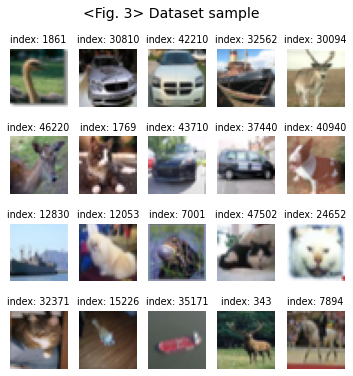

In [3]:
plt.figure(figsize=(6, 6))
plt.suptitle("<Fig. 3> Dataset sample", fontsize=14)
plt.subplots_adjust(top=0.9)

for i in range(20):
    plt.subplot(4, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index].reshape(32, 32, 3))
    plt.title(f'index: {random_index}', size=9.5)
    plt.axis('off')
plt.show()

<br>

### 2.2. 데이터 전처리
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 학습의 효율을 위하여 이미지 처리에 주로 사용되는 'Zero-mean 정규화'를 사용한다. 또한, 데이터셋을 만들어 학습 시 메모리를 절약 한다.
</span>

***

#### zero-mean 정규화
***
+ 평균에 해당하는 127.5를 차감하고 나누어 'zero-mean' 정규화를 시행한다.
***

In [4]:
dataset = (dataset - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", dataset.max())
print("min pixel:", dataset.min())

max pixel: 1.0
min pixel: -1.0


<br>

#### 데이터셋 생성
***
+ 데이터를 무작위로 섞어 준 후, 256크기의 배치사이즈로 데이터셋을 생성한다.
***

In [5]:
BUFFER_SIZE, BATCH_SIZE = 50000, 256
train_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

<br>

### 2.3. 모델 생성
***
<img src="./img/fig3.jpg" width=800></img>

&lt;Fig.4> DCGAN 생성자 아키텍쳐, https://arxiv.org/abs/1511.06434

<br><br><span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; &lt;Fig. 4>는 Alec Radford 와 Luke Metz가 제시한 Deep Convolution GAN의 생성자 모델 아키텍쳐이다[2]. 본 고찰에서 사용되는 데이터셋은 CIFAR-10으로 32 크기의 3채널 이미지 이다. 해당 논문에서 제시하는 아키텍쳐의 출력은 64크기의 이미지 이므로 온전히 동일하게 모델을 설계할 수 없었다. 따라서 Convolution 레이어의 개수는 3개로 동일하게 생성하되, 마지막 레이어의 stride를 1로 설정하여 최종 출력을 32로 맞추었다. 또한, 판별자의 경우 생성자의 아키텍쳐와 대칭이 되도록 생성하였다.
</span>

***

### 2.3.1. 생성자 모델 생성
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 생성자는 100 크기의 벡터를 입력으로 받아 최종적으로 32크기의 3채널 이미지를 출력한다. Alec Radford 와 Luke Metz가 제시한 모델을 중심으로 4 * 4 * 1,024 크기의 밀집층 이후 세 개의 Convolution 레이어를 추가하였다. &lt;Fig. 5>는 생성자 모델을 시각화 한 것이다.
</span><br><br>

<img src="./img/generator.png" width=400></img>

&lt;Fig. 5> Generator Model

***

<br>

#### 생성자 모델 생성
***
+ 생정자 모델을 생성하고 그 요약을 출력한다.
***

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(4 * 4* 1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 1024)))

    model.add(layers.Conv2DTranspose(512, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
 
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(
        3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'
    ))

    return model

generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 512)         13107200  
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 512)         0

<br>

### 2.3.2. 판별자 모델 생성
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 판별자 모델을 생성한다. 판별자 모델은 생성자 모델과 대칭되도록 하였다. &lt;Fig. 6>는 판별자 모델을 시각화 한 것이다.
</span><br><br>

<img src="./img/discriminator.png" width=400></img>

&lt;Fig. 6> Discriminator Model

***

#### 판별자 모델 생성
***
+ 판별자 모델을 생성하고 그 요약을 출력한다.
***

In [7]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=(32, 32, 3)))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
 
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Flatten())
    
    model.add(layers.Dense(4 * 4 * 1024, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(1))
    return model

discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 128)       9728      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 512)         3277312   
_________________________________________________________________
batch_normalization_5 (Batch (None, 4, 4, 512)        

<br>

### 2.4. 필요 함수 정의
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 모델 학습 시 이용되는 손실함수, 옵티마이저, 학습 과정에 대한 함수를 생성한다. 손실함수는 생성자, 판별자 두 모델에 적용되는 각기 다른 함수를 정의할 필요가 있다. 또한, 옵티마이저는 'Adam'을 사용하며, 학습 과정 시에 생성자가 생성한 이미지를 시각화 하기 위한 함수, 학습과정 중의 손실값 및 정확도를 시각화하는 등의 함수를 생성하여 준다.
</span>

***

#### 생성자 및 판별자 모델의 손실 함수 정의
***
+ 생성자 모델의 손실함수는 판별자 모델의 출력을 기반으로 한다.


+ 판별자 모델의 손실함수는 생성자 모델의 출력과 실제 이미지를 기반으로 한다.
***

In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#생성자 모델 손실함수===============================
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
#End================================================


#판별자 모델 손실함수===============================
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
#End================================================

<br>

#### 판별자 모델 정확도 함수 생성
***
+ 판별자 모델의 '가짜 이미지에 대한 정확도'와 '진짜 이미지에 대한 정확도'를 출력하는 함수를 생성한다.
***

In [9]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

<br>

#### 옵티마이저 설정
***
+ 생성자, 판별자 모두 Adam을 사용하며, 학습률은 동일하게 설정한다.
***

In [10]:
generator_optimizer = tf.keras.optimizers.Adam(0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0001)

<br>

#### 학습 과정 함수 생성
***
+ 실제 손실값에 따른 역전파가 이루어지는 과정을 함수화 한다.
***

In [23]:
#학습 과정 중 생성자의 출력 확인을 위한 노이즈 행렬==============
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
#End=============================================================


@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

<br>

#### 학습 과정에 따른 생성자의 출력물 시각화 및 저장 함수
***
+ 학습 중, 생성자가 새롭게 만들어내는 이미지를 시각화 및 저장하는 함수를 생성한다.
***

In [24]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i] * 127.5 + 127.5).astype('uint8'))
        plt.axis('off')
   
    plt.savefig(
        '/aiffel/aiffel/ex/ex13/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it)
    )

    plt.show()

<br>

#### 학습 과정에 따른 손실값 및 정확도 변화 시각화 및 저장 함수
***
+ 학습 과정 중 변화하는 손실값과 정확도를 시각화 및 저장하는 함수를 생성한다.
***

In [25]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    plt.subplots_adjust(hspace=0.45)
    
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'], alpha=0.5)  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'], alpha=0.5)  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig(
        '/aiffel/aiffel/ex/ex13/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'.format(epoch)
    )
    plt.show()

<br>

#### 통합 함수
***
+ 앞의 학습 과정, 생성자 출력물 시각화 및 저장, 손실값 및 정확도 시각화 및 저장 함수를 통합 한다.
***

In [27]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

<br>

#### 체크포인트 생성
***
+ 학습 과정에 있어 주기적으로 모델을 저장하도록 체크포인트를 생성한다.
***

In [25]:
checkpoint_dir = '/aiffel/aiffel/ex/ex13/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

<br>

#### 생성자 출력 이미지 GIF화 함수 생성
***
+ 생성자가 만들어내는 이미지를 GIF 파일로 생성하는 함수를 정의한다.
***

In [5]:
anim_file = './dcgan_newimage/cifar10/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/aiffel/aiffel/ex/ex13/dcgan_newimage/cifar10/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

<br>

#### 학습 하이퍼파라미터 설정
***
+ 학습 횟수, 체크포인트 저장 주기를 설정한다.
***

In [28]:
tf.config.list_physical_devices("GPU")
save_every = 10
EPOCHS = 256

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

<br>

## 3. 기본 모델
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 앞서 생성한 기본적인 모델을 사용하여 학습한다. 최종 Epoch는 232이며, 'Fake accuray'가 소폭 감소하는 것을 확인할 수 있다. 그러나 생성자가 구분 가능한 객체를 출력하지는 못하였다. 다음은 기본 모델이 출력한 이미지를 제시한 것이다.
</span>

***

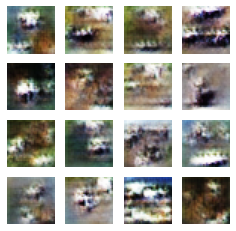

Epoch 232 | iter 1
Time for epoch 232 : 2 sec


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

<img src="./img/try1_history.png"></img>

<br>

#### 학습 과정에 따른 생성자의 출력 이미지 시각화
***
<img src="./img/try1_img.png"></img>

<img src="./img/try1.gif"></img>
***

<br>

## 4. 생성자와 판별자 간의 불균형
***
<img src="./img/fig2.png" width=800></img>

&lt;Fig. 2> 생성자와 판별자 사이의 불균형

<br><br><span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 고찰의 작성자는 생성자와 판별자 사이에 있어 학습이 불균형 적으로 이루어지는 것에 주목하였다. 생성자는 새로운 이미지를 생성한 다는 점에있어 판별자에 비해 어려움이 따른다. 반대로 판별자는 이미지를 보고 진위 여부를 판단하는 것이기 때문에 생성자의 그것보다 쉽다. 따라서 판별자는 생성자 보다 더 빠르게 손실을 낮출 수 있다. 즉, 빠르게 학습할 수 있다. 하지만 생성자는 그러지 못한다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 그리고 이러한 모델 간의 불균형은 생성자의 이미지 생성에 부정적인 영향을 미친다. 판별자는 생성자의 가짜 이미지를 손 쉽게 구분한다면, 생성자의 입장에서는 진짜와 가짜 사이의 차이를 알 수 없다. 즉, 판별자가 생성자가 생성한 모든 이미지에 대해 0이라는 값을 출력하면, 생성자의 입장에서는 어찌할 도리가 없는 것이다. 즉, 생성자와 판별자 사이의 균형이 필요하다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 결국 이러한 문제는 판별자 문제가 더 쉽기 때문에 발생한다고 보았다. 따라서, 판별자를 어느정도 '바보로 만들어야 한다'고 생각 했다. 또, '판별자는 생성자가 어느정도 학습 할 때까지 기다려 줄 필요가 있다'고 생각 했다. 이러한 고찰을 바탕으로 다음 세 방법을 제시한다. 첫 번째, 판별자 모델을 물리적 축소한다. 두 번째, 판별자의 학습률을 더 낮게 설정하여 학습 속도를 조절한다. 세 번째, 생성자의 손실값에 맞추어 판별자의 손실값을 조절한다.
</span>

***

<br>

## 5. 판별자 모델의 물리적 축소
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 판별자 모델을 물리적으로 축소하기 위해 '밀집층 축소', 'Convolution 필터 수 축소', 'Convolution 레이어 층 축소'를 시행하였다. 밀집층 축소는 기존 4 * 4 * 1024의 크기에서 4 * 4 * 512의 크기로 축소하였다. Convolution 필터 수 축소는 모든 Convolution 레이어의 필터 수를 반으로 축소하였다. 또한, Convolution 레이어 층 축소는 3개의 층 중, 하나의 층만 제외하였다. 또한, 밀집층 축소는 뚜렷한 성능 개선을 확인할 수 없어 Convolution 필터 수 축소와 함께 진행하였다.
</span>

***

### 5.1. 밀집층 축소 및 Convolution 필터 수 축소
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 밀집층 축소 및 Convolution 필터 수 축소를 함께 시행하였다. 밀집층은 기존 모델의 4 * 4 * 1024 크기에서 4 * 4 * 512로 축소하였다. Convolution 필터 수는 기존 모델의 필터 수의 반으로 축소 하여 시행하였다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Epoch은 총 256회 시행하였다. 생성자의 손실값은 서서히 상승하다 감소하는 형태를 보였으며, 2 ~ 8사이의 큰 폭으로 횡보하며 학습이 진행 된 것을 확인할 수 있다. 기본 모델이 생성한 이미지는 뚜렷한 객체를 찾을 수 없었지만 해당 모델에서는 새 또는 비행기와 같이 어렴풋한 객체를 구분할 수 있는 이미지를 생성하였다.
</span>

***

#### 밀집층 축소 및 Convolution 필터 수 축소 예시
***
+ 밀집층은 4 * 4 * 512로 축소한다.


+ Convolution 필터 수는 기본 모델의 반으로 축소한다.
***

In [ ]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=(32, 32, 3)))
    model.add(layers.LeakyReLU())

    # Second: Conv2D Layer
    model.add(layers.Conv2D(164, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Third: Flatten Layer
    model.add(layers.Flatten())
    
    model.add(layers.Dense(4 * 4 * 512, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

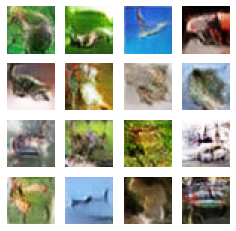

Time for training : 56466 sec


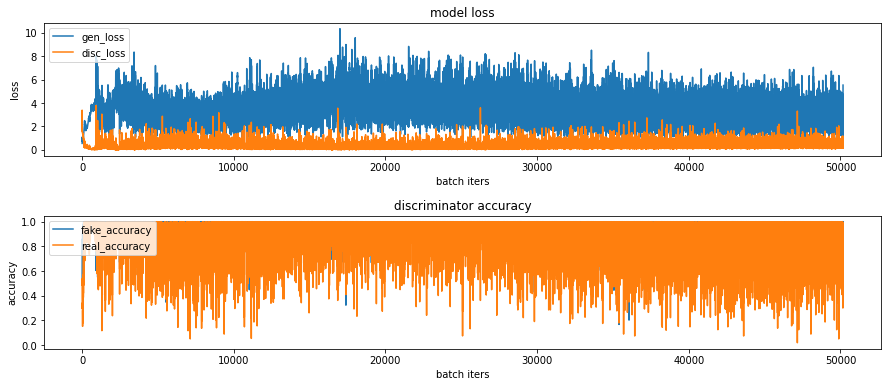

CPU times: user 11h 9min 59s, sys: 4h 30min 51s, total: 15h 40min 50s
Wall time: 15h 41min 9s


In [28]:
%%time
train(train_dataset, EPOCHS, save_every)

<br>

#### 학습 과정에 따른 생성자의 출력 이미지 시각화
***
<img src="./img/try2_img.png"></img>

<img src="./img/try2.gif"></img>
***

<br>

### 5.2. Convolution 레이어 축소
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 밀집층 축소와 Convolution 레이어 축소를 적용한 모델을 학습하였다. 기본 모델에서 세 개였던 Convolution 레이어를 한 층 제거하여 두 개만 이용하였다. 총 Epoch은 174회 이며, 앞의 밀집층 축소 및 Convolution 필터 축소 모델에 비해 생성자의 손실값의 변동폭이 1에서 3사이로 작아진 것을 확인할 수 있다. 생성자가 출력한 이미지로부터 사슴 혹은 말과 같은 사족보행 동물의 형체를 어렴풋이 확인할 수 있다. 앞의 밀집층 축소 및 필터 수 축소 모델에 비해 뚜렷하지 않은 이미지를 출력한다.
</span>

***

#### Convolution 레이어 축소 예시
***
+ 밀집층은 4 * 4 * 512로 축소한다.


+ Convolution 레이어 수를 두 개로 축소한다.
***

In [ ]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=(32, 32, 3)))
    model.add(layers.LeakyReLU())

    # Second: Conv2D Layer
    model.add(layers.Conv2D(164, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Third: Flatten Layer
    model.add(layers.Flatten())
    
    model.add(layers.Dense(4 * 4 * 512, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

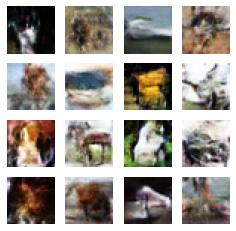

Epoch 174 | iter 101
Time for epoch 174 : 94 sec


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

<img src="./img/try3_history.png"></img>

<br>

#### 학습 과정에 따른 생성자의 출력 이미지 시각화
***
<img src="./img/try3_img.png"></img>

<img src="./img/try3.gif"></img>
***

<br>

## 6. 옵티마이저 설정 변경
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 위의 Convolution 레이어 축소 모델의 옵티마이저의 설정을 변경하여 학습을 진행하였다. 생성자의 학습률은 기존 0.0001에서 0.0002로 증가시켰다. 반대로 판별자의 학습 속도를 늦추기 위해 기존 0.0001에서 0.00005로 낮추었다. Epoch은 149회 진행 하였다. 그 결과, 생성자의 손실값 변동이 앞선 모든 모델과 비교하였을 때, 그 폭이 크지 않음을 확인할 수 있었다. 또한, 판별자의 정확도가 서서히 증가하는 것을 확인하였다. 생성자가 출력한 이미지를 앞선 모든 모델이 출력한 이미지들과 비교하였을 때, 가장 좋은 성능을 제시하였다. 말, 자동차와 같은 객체를 확인할 수 있다.
</span>

***

#### 옵티마이저 설정 변경 예시
***
+ 생성자의 옵티마이저는 0.0001에서 0.0002로 설정한다.


+ 판별자의 옵티마이저는 0.0001에서 0.00005로 설정한다.
***

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(0.0002)
discriminator_optimizer = tf.keras.optimizers.Adam(0.00005)

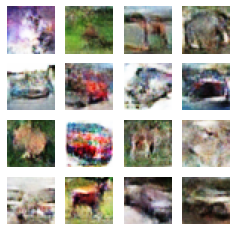

Epoch 149 | iter 151
Time for epoch 149 : 141 sec


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

<img src="./img/try4_history.png"></img>

<br>

#### 학습 과정에 따른 생성자의 출력 이미지 시각화
***
<img src="./img/try4_img.png"></img>

<img src="./img/try4.gif"></img>
***

<br>

## 7. 지연항 도입
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Convolution 레이어 축소 모델을 베이스로 지연항을 도입하였다. 지연항은 생성자의 손실값을 바탕으로 판별자의 손실값을 조절하는 것이다. 기본 아이디어는 생성자의 손실값이 큰 경우, 생성자와 판별자 간의 격차가 큰 것으로 판단하고 판별자의 기존 손실값에 낮은 값을 곱하여 판별자의 학습을 지연시키는 것이다. 따라서 지연항은 생성자의 손실값이 커질수록 값이 점점 작아지도록 설정할 필요가 있다. 최종적으로 사용한 지연항은 다음과 같으며, &lt;Fig. 3>은 지연항의 함수를 시각화 한 것이다.
</span><br><br>

$$\min\left(1,\ \frac{1}{e^{\left(x-0.5\right)}}+0.1\right)$$

<br><br><img src="./img/fig10.jpg" width=500></img><br><br>

&lt;Fig. 3> 지연항 함수

<br><br><span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 지연항을 적용하여 학습을 진행한 결과, 베이스 모델인 Convolution 레이어 축소 모델과 비교하였을 때, 학습 과정에 있어 손실값 및 정확도의 뚜렷한 변화를 확인할 수 없었다. Epcoh는 205회 진행하였다. 생성자가 출력한 이미지로부터 확실한 객체를 확인하지 못하였다.
</span>

***

#### 지연항 함수 생성
***
+ 생성자의 손실값을 입력받으면 판별자의 손실값을 얼마나 낮출지 계산한다.
***

In [ ]:
 def cal_gamma(x):
    x -= 0.5
    x = tf.math.exp(x)
    x = tf.divide(1, x)
    x += 0.1
    
    return tf.math.minimum(1., x)

<br>

#### 판별자 손실값과 지연항의 연산
***
+ 앞서 구한 지연항과 판별자의 손실값을 곱하여 판별자의 최종 손실값으로 사용한다.
***

In [ ]:
gamma = cal_gamma(gen_loss)
        disc_loss = discriminator_loss(real_output, fake_output)
        disc_loss *= gamma

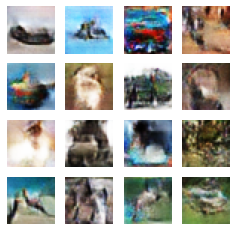

Epoch 205 | iter 1
Time for epoch 205 : 3 sec


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

<img src="./img/try5_history.png"></img>

<br>

#### 학습 과정에 따른 생성자의 출력 이미지 시각화
***
<img src="./img/try5_img.png"></img>

<img src="./img/try5.gif"></img>
***

<br>

## 8. 결론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; DC GAN 모델의 생성자와 판별자 간의 학습에 있어서의 균형에 대한 고찰을 작성하였다. 나아가 이를 해결하기 위해 '모델 축소', '옵티마이저 설정', '지연항 적용'의 총 세 방법을 제시하고 직접 적용하고 평가해 보았다. 궁극적으로 각 개선 모델 간의 성능에는 차이가 있었지만, 모두 기본모델과 비교하였을 때 좋은 성능을 제시 하였다. 그중 옵티마이저를 설정한 모델이 가장 뚜렷하고 구분 가능한 객체의 이미지를 출력하였다. [표 1]은 본 고찰의 모델의 평가를 제시한 것이다. 해당 평가는 상당히 주관적인 것이기 때문에 추후, 'ResNet 모델을 이용하여 객체에 대한 확률분포를 이용한 평가'와 같이 좀 더 객관적인 평가모델을 제시할 필요가 있다.
</span><br><br>

|Model|생성자 손실값 변동폭|생성자 정확도 감소 여부|객체 육안 구분가능 여부|
|:--------:|:--------:|:--------:|:--------:|
|**Original**|1 ~ 2|Y|N|
|**reduce Dense & filter**|2 ~ 6|N|Y|
|**reduce layer**|1 ~ 3|N|△|
|**change optimizer**|1 ~ 2|N|Y|
|**delay term**|3 ~ 5|N|△|

[표 1] 모델에 따른 평가

***

#### 참고문헌
***
[1] Charu C. Aggarwal, 『Neural Networks and Deep Learning: A Textbook』(2019), Springer, 66-67.

[2] Alec Radford & Luke Metz, UNSUPERVISED REPRESENTATION LEARNING WITH DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS, arXiv:1511.06434v2, 2016.

***

#### 형상관리 기록
***
+ v1_1: 초기모델


+ v1_2: 본 예제 진행


+ v2_1: 논문 모델 적용


+ v3_1: 판별자 밀집층 사이즈 축소


+ v4_1: 판별자 Conv 필터 수 축소


+ v5_1: 판별자 Conv 레이어 한 층 제거


+ v6_1: 판별자 learning late 설정


+ v7_1: 학습 중단으로 인한 재개


+ v8_1: 판별자 지연항(gamma) 추가


+ v9_1-5: 모델 결과 통합
***